In [1]:
# Python code to simulate a toy seasonal surface temperature model using "radiative kernels"
# and to decompose the seasonal cycle into direct (forced) contributions and feedback contributions.
#
# The code is intentionally self-contained and uses simplified parameterizations so you can
# adapt it to real kernels and observed forcings later.
#
# Follows the user's request for Google-style docstrings and typed function signatures.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, Dict

def day_of_year_to_solar_declination(day: int) -> float:
    """
    Compute approximate solar declination angle (radians) for a given day of year.

    Args:
        day (int): day of year (1-365)

    Returns:
        float: solar declination in radians
    """
    # approximate formula (Cooper, Ball, etc.): declination = 23.44° * sin(2π*(284+day)/365)
    return np.deg2rad(23.44) * np.sin(2 * np.pi * (day - 81) / 365.0)

def daily_top_of_atmosphere_insolation(latitude_deg: float, day: int, S0: float = 1361.0) -> float:
    """
    Compute daily-averaged TOA insolation (W/m2) for a given latitude and day using a simple
    analytic approximation (integrated over the day, neglecting eccentricity effects).

    Args:
        latitude_deg (float): latitude in degrees (positive north)
        day (int): day of year (1-365)
        S0 (float): solar constant (W/m2), default 1361

    Returns:
        float: daily mean TOA insolation (W/m2)
    """
    # This is a simple approximation: S0/pi * (daily average of cos(zenith) for sunlit fraction)
    lat = np.deg2rad(latitude_deg)
    decl = day_of_year_to_solar_declination(day)
    # hour angle of sunrise (radians)
    cos_omega0 = -np.tan(lat) * np.tan(decl)
    # clamp
    cos_omega0 = np.clip(cos_omega0, -1.0, 1.0)
    omega0 = np.arccos(cos_omega0)
    # daily average of insolation on a horizontal plane (see standard formula)
    # daily mean = (S0 / np.pi) * (omega0 * np.sin(lat) * np.sin(decl) + np.cos(lat) * np.cos(decl) * np.sin(omega0))
    daily_mean = (S0 / np.pi) * (omega0 * np.sin(lat) * np.sin(decl) + np.cos(lat) * np.cos(decl) * np.sin(omega0))
    return float(daily_mean)


def planck_surface_sensitivity(Tkelvin: float) -> float:
    """
    Compute the Planck (LW) sensitivity at the surface: dF/dT ≈ 4 * sigma * T^3 (W m^-2 K^-1).

    Args:
        Tkelvin (float): surface temperature in Kelvin

    Returns:
        float: dLW_net/dT (W m^-2 K^-1), negative sign for net cooling is applied externally
    """
    sigma = 5.670374419e-8
    return 4.0 * sigma * (Tkelvin ** 3)


def run_seasonal_model(
    latitude: float = 55.97,
    year_days: int = 365,
    C: float = 2.0e7,
    T0: float = 273.15 + 5.0,
    transmissivity_clear: float = 0.7,
    K_cloud_SW: float = -80.0,
    K_RH_LW: float = +2.0,
    k_turbulent: float = 5.0,
    RH_feedback_perK: float = -0.01,
    cloud_feedback_perK: float = -0.02,
    forced_RH_amplitude: float = 0.08,
    forced_cloud_amplitude: float = 0.15,
    dt_days: float = 1.0
) -> Dict[str, pd.DataFrame]:
    """
    Run a toy daily seasonal surface-temperature model and decompose the surface flux contributions
    into direct (forced) and feedback parts.

    The model is intentionally simple:
     - energy balance: C dT/dt = SW_to_surface + LW_net + SH_plus_LH (turbulent)
     - SW_to_surface = transmissivity_clear * TOA_insolation * (1 - cloud_fraction * cloud_sw_effect)
       but we handle clouds via kernel multiplication: SW contribution from insolation and clouds
     - LW_net ~ -Planck(T) + vapor/cloud greenhouse terms approximated as linear in RH and cloud fraction
     - SH+LH ~ - k_turbulent * (T - T_ref)  (a linearized loss to the atmosphere)
     - RH and cloud fraction each have a 'forced' seasonal cycle (sinusoidal) PLUS a linear feedback
       proportional to (T - T_ref): x(t) = x_forced(t) + f_x * (T - T_ref)

    Args:
        latitude (float): latitude (deg N) for insolation calc.
        year_days (int): number of days in model (default 365)
        C (float): effective heat capacity (J m^-2 K^-1)
        T0 (float): initial/reference surface temperature (K)
        transmissivity_clear (float): clear-sky surface transmissivity (0-1)
        K_cloud_SW (float): SW sensitivity to cloud fraction (W m^-2 per unit cloud fraction)
        K_RH_LW (float): LW sensitivity per unit relative humidity (W m^-2 per unit RH)
        k_turbulent (float): linear turbulent flux coefficient (W m^-2 K^-1)
        RH_feedback_perK (float): how much RH changes per K of surface warming (units RH per K)
        cloud_feedback_perK (float): how much cloud fraction changes per K of surface warming (unit cloud fraction per K)
        forced_RH_amplitude (float): amplitude of forced sinusoidal RH (peak-to-mean)
        forced_cloud_amplitude (float): amplitude of forced sinusoidal cloud fraction
        dt_days (float): time step in days (default 1)

    Returns:
        dict: dictionary of pandas DataFrames with keys:
          - 'state': Time series of T, RH_total, cloud_total
          - 'forcings': time series of forced (independent) components
          - 'contribs': instantaneous contributions to net surface energy balance from each term
          - 'decomp': decomposition into forced vs feedback contributions for each term (SW_insolation, SW_cloud, LW_RH, turbulent)
    """
    # time array
    days = np.arange(1, year_days + 1)
    n = len(days)
    dt = dt_days * 86400.0  # convert days to seconds for heat capacity equation

    # arrays to store
    T = np.zeros(n) + T0  # Kelvin
    RH = np.zeros(n)
    cloud = np.zeros(n)
    TOA = np.zeros(n)

    # For decomposition we track 'forced' component and 'feedback component' of RH and cloud
    RH_forced = np.zeros(n)
    cloud_forced = np.zeros(n)
    RH_feedback_component = np.zeros(n)
    cloud_feedback_component = np.zeros(n)

    # contributions
    SW_insolation_flux = np.zeros(n)
    SW_cloud_flux = np.zeros(n)
    LW_planck_flux = np.zeros(n)
    LW_RH_flux = np.zeros(n)
    turbulent_flux = np.zeros(n)
    net_flux = np.zeros(n)

    # forced seasonal cycles (sinusoidal) phases: assume peak insolation at day ~ 172 (June 21)
    # For RH and cloud we give a simple sinusoid with adjustable amplitude; these are the 'external' forced variations.
    phase_shift = -81  # aligns day 172 as peak for insolation in our declination func
    # Normalize amplitude so forced_RH_amplitude is roughly the amplitude around T0
    for i, day in enumerate(days):
        TOA[i] = daily_top_of_atmosphere_insolation(latitude, int(day))
        # forced components: choose simple sinusoids in phase with insolation for this demo
        RH_forced[i] = 0.5 + forced_RH_amplitude * np.sin(2 * np.pi * (day - 172) / 365.0)  # mean RH ~0.5
        cloud_forced[i] = 0.5 + forced_cloud_amplitude * np.sin(2 * np.pi * (day - 200) / 365.0)  # phase slightly shifted

    # reference T and values
    T_ref = T0
    RH_ref = np.mean(RH_forced)
    cloud_ref = np.mean(cloud_forced)

    # Run forward Euler integration day-by-day
    for i, day in enumerate(days):
        # compute feedback parts based on current T (note: use T[i] which is current day's T)
        RH_feedback_component[i] = RH_feedback_perK * (T[i] - T_ref)
        cloud_feedback_component[i] = cloud_feedback_perK * (T[i] - T_ref)
        RH[i] = RH_forced[i] + RH_feedback_component[i]
        cloud[i] = cloud_forced[i] + cloud_feedback_component[i]
        # clip physical bounds
        RH[i] = np.clip(RH[i], 0.01, 0.99)
        cloud[i] = np.clip(cloud[i], 0.0, 1.0)

        # compute surface SW contributions:
        # direct insolation -> surface via transmissivity (ignoring angular dependence within day here)
        SW_from_insolation = transmissivity_clear * TOA[i]
        # cloud contribution: kernel times cloud fraction anomaly from reference (kernel negative for more cloud -> less SW)
        SW_from_cloud = K_cloud_SW * (cloud[i] - cloud_ref)

        # LW contributions:
        # planck cooling (approx) dF = -Planck * (T - T_ref)
        planck_sens = planck_surface_sensitivity(T[i])
        LW_from_planck = -planck_sens * (T[i] - T_ref)
        # LW greenhouse effect from RH and cloud (simple linear sensitivities)
        LW_from_RH = K_RH_LW * (RH[i] - RH_ref)
        LW_from_cloud_LW = 15.0 * (cloud[i] - cloud_ref)  # additive LW greenhouse effect per cloud frac unit

        # turbulent flux (sensible+latent) parameterized as linear sink ~ -k_turbulent*(T-T_ref)
        turbulent = -k_turbulent * (T[i] - T_ref)

        # net flux into surface (W/m2)
        net = SW_from_insolation + SW_from_cloud + LW_from_planck + LW_from_RH + LW_from_cloud_LW + turbulent

        # store instantaneous contributions
        SW_insolation_flux[i] = SW_from_insolation - transmissivity_clear * np.mean(TOA)  # transmit anomaly relative to mean
        SW_cloud_flux[i] = SW_from_cloud
        LW_planck_flux[i] = LW_from_planck
        LW_RH_flux[i] = LW_from_RH
        turbulent_flux[i] = turbulent
        net_flux[i] = net

        # advance temperature to next day via forward Euler (T_{n+1} = T_n + (net/C)*dt)
        if i < n - 1:
            T[i + 1] = T[i] + (net / C) * dt

    # Build DataFrames
    df_state = pd.DataFrame({
        "day": days,
        "T": T,
        "RH_total": RH,
        "RH_forced": RH_forced,
        "RH_feedback": RH_feedback_component,
        "cloud_total": cloud,
        "cloud_forced": cloud_forced,
        "cloud_feedback": cloud_feedback_component,
        "TOA": TOA
    }).set_index("day")

    df_forcings = pd.DataFrame({
        "TOA": TOA,
        "SW_transmissivity_mean_TOA_anom": SW_insolation_flux + transmissivity_clear * np.mean(TOA)  # also store raw
    }, index=days)

    df_contribs = pd.DataFrame({
        "SW_insolation": SW_insolation_flux,
        "SW_cloud": SW_cloud_flux,
        "LW_planck": LW_planck_flux,
        "LW_RH": LW_RH_flux,
        "LW_cloud": 15.0 * (cloud - cloud_ref),
        "Turbulent": turbulent_flux,
        "Net_flux": net_flux
    }, index=days)

    # Decomposition into forced vs feedback contributions for variables that are mixtures:
    # For SW_cloud and LW_RH and LW_cloud we can split into contribution due to forced component of cloud/RH
    # vs due to their feedback component (which is proportional to (T-T_ref)).
    SW_cloud_forced = K_cloud_SW * (cloud_forced - cloud_ref)
    SW_cloud_feedback = K_cloud_SW * cloud_feedback_component
    LW_RH_forced = K_RH_LW * (RH_forced - RH_ref)
    LW_RH_feedback = K_RH_LW * RH_feedback_component
    LW_cloud_forced = 15.0 * (cloud_forced - cloud_ref)
    LW_cloud_feedback = 15.0 * cloud_feedback_component

    df_decomp = pd.DataFrame({
        "SW_insolation_direct": SW_insolation_flux,
        "SW_cloud_forced": SW_cloud_forced,
        "SW_cloud_feedback": SW_cloud_feedback,
        "LW_planck": LW_planck_flux,
        "LW_RH_forced": LW_RH_forced,
        "LW_RH_feedback": LW_RH_feedback,
        "LW_cloud_forced": LW_cloud_forced,
        "LW_cloud_feedback": LW_cloud_feedback,
        "Turbulent": turbulent_flux,
        "Net_flux": net_flux
    }, index=days)

    return {
        "state": df_state,
        "forcings": df_forcings,
        "contribs": df_contribs,
        "decomp": df_decomp
    }


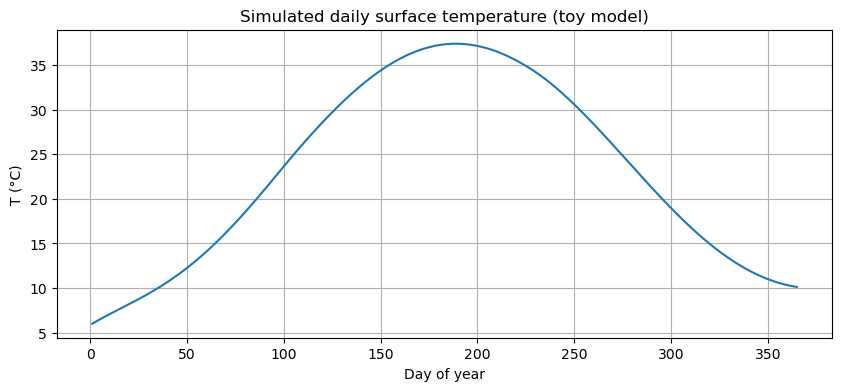

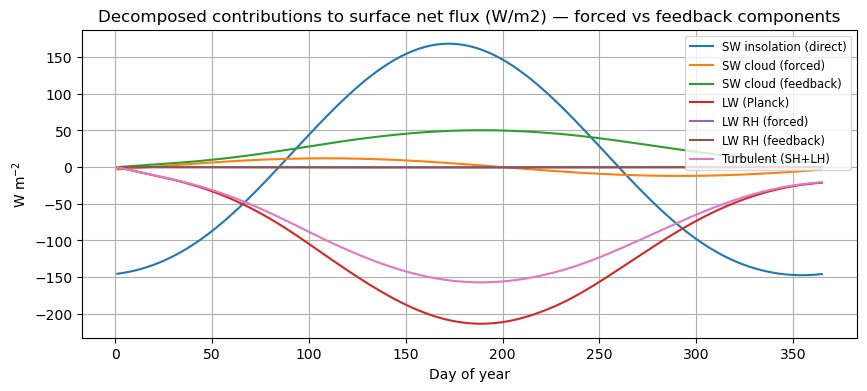

Rough seasonal amplitude (peak-to-peak) of contributions (W/m2):
LW_planck               213.403565
SW_insolation_direct    168.040014
Turbulent               157.057062
Net_flux                 60.629446
SW_cloud_feedback        50.258260
SW_cloud_forced          11.999889
LW_cloud_feedback         9.423424
LW_cloud_forced           2.249979
LW_RH_feedback            0.628228
LW_RH_forced              0.159999


In [2]:
# Run the toy model for a mid-latitude site (St Andrews-like ~56N)
results = run_seasonal_model(latitude=56.34, year_days=365, C=2.0e7, T0=273.15+6.0)

# Plot results: follow python_user_visible rules: use matplotlib, single plot per figure, no seaborn, no preset colors.
state = results["state"]
contribs = results["contribs"]
decomp = results["decomp"]

plt.figure(figsize=(10,4))
plt.plot(state.index, state["T"] - 273.15)  # Celsius
plt.title("Simulated daily surface temperature (toy model)")
plt.ylabel("T (°C)")
plt.xlabel("Day of year")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(decomp.index, decomp["SW_insolation_direct"], label="SW insolation (direct)")
plt.plot(decomp.index, decomp["SW_cloud_forced"], label="SW cloud (forced)")
plt.plot(decomp.index, decomp["SW_cloud_feedback"], label="SW cloud (feedback)")
plt.plot(decomp.index, decomp["LW_planck"], label="LW (Planck)")
plt.plot(decomp.index, decomp["LW_RH_forced"], label="LW RH (forced)")
plt.plot(decomp.index, decomp["LW_RH_feedback"], label="LW RH (feedback)")
plt.plot(decomp.index, decomp["Turbulent"], label="Turbulent (SH+LH)")
plt.title("Decomposed contributions to surface net flux (W/m2) — forced vs feedback components")
plt.xlabel("Day of year")
plt.ylabel("W m$^{-2}$")
plt.legend(loc="upper right", fontsize="small")
plt.grid(True)
plt.show()

# Also produce a stacked-like view for the magnitudes (absolute seasonal amplitude)
amps = decomp.abs().max() - decomp.abs().min()
amps = amps.sort_values(ascending=False)
print("Rough seasonal amplitude (peak-to-peak) of contributions (W/m2):")
print(amps.to_string())

# Provide outputs as dataframes for inspection
# import caas_jupyter_tools as cjt
# cjt.display_dataframe_to_user("Model state (daily)", state)
# cjt.display_dataframe_to_user("Contributions (daily)", contribs)
# cjt.display_dataframe_to_user("Decomposition (daily)", decomp)

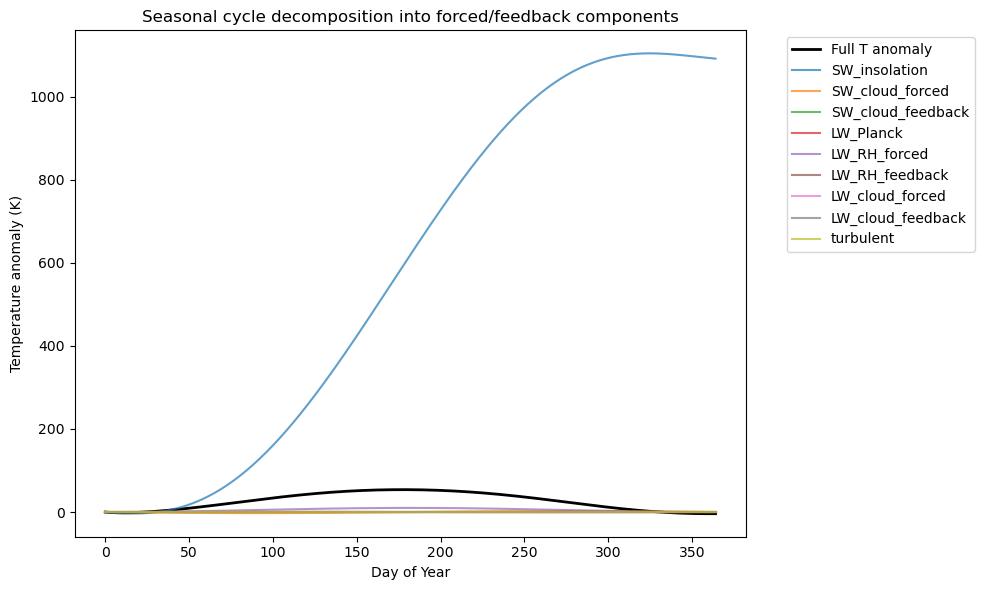

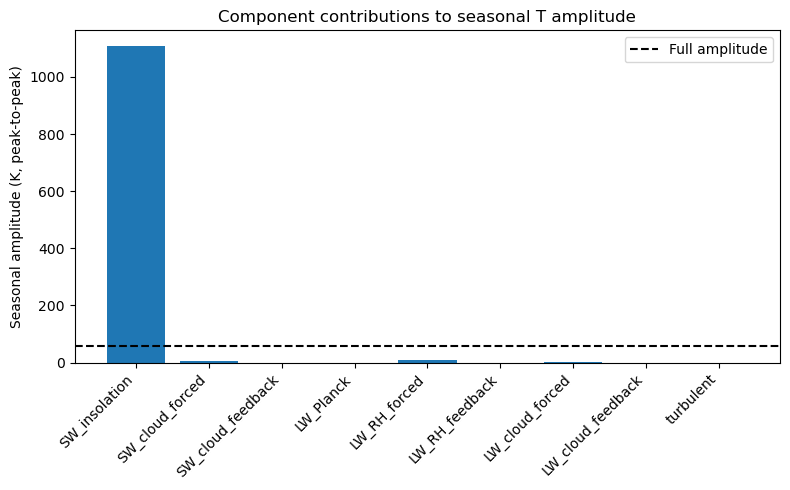

In [3]:
# Parameters
days = np.arange(365)
lat = 45.0 * np.pi / 180  # latitude in radians
C = 1e7  # mixed layer heat capacity J/m²/K
dt = 86400  # one day in seconds

# Orbital parameters
def daily_insolation(day, lat):
    # Declination angle
    decl = 23.44 * np.pi / 180 * np.sin(2 * np.pi * (day - 80) / 365)
    # Day length fraction
    cosH = -np.tan(lat) * np.tan(decl)
    cosH = np.clip(cosH, -1, 1)
    H = np.arccos(cosH)
    daylength = 2 * H / (2 * np.pi)
    # TOA insolation (simplified)
    S0 = 1361
    return S0 * (daylength * np.cos(lat) * np.cos(decl) + np.sin(lat) * np.sin(decl))

S = np.array([daily_insolation(d, lat) for d in days])
transmissivity_clear = 0.75

# Kernel parameters (toy values)
K_cloud_SW = -50.0    # W/m2 per unit cloud fraction
K_RH_LW = 2.0         # W/m2 per %RH anomaly
K_cloud_LW = 15.0     # W/m2 per unit cloud fraction
k_turbulent = 10.0    # W/m2/K
sigma = 5.67e-8

# Reference state
T_ref = 288.0
RH_ref = 0.7
cloud_ref = 0.4

# Seasonal forcing terms (toy sinusoids)
RH_forced = RH_ref + 0.05 * np.sin(2 * np.pi * days / 365)
cloud_forced = cloud_ref + 0.1 * np.cos(2 * np.pi * days / 365)

# Feedback sensitivities
RH_feedback_perK = 0.01
cloud_feedback_perK = -0.005

# Helper function: integrate with chosen active components
def integrate_model(active):
    T = np.zeros_like(days, dtype=float)
    T[0] = T_ref
    for t in range(1, len(days)):
        Ts = T[t-1]
        RH = RH_forced[t] + RH_feedback_perK * (Ts - T_ref)
        cloud = cloud_forced[t] + cloud_feedback_perK * (Ts - T_ref)

        flux = 0.0
        if "SW_insolation" in active:
            flux += S[t] * transmissivity_clear
        if "SW_cloud_forced" in active:
            flux += K_cloud_SW * (cloud_forced[t] - cloud_ref)
        if "SW_cloud_feedback" in active:
            flux += K_cloud_SW * (cloud - cloud_forced[t])
        if "LW_Planck" in active:
            flux -= 4 * sigma * T_ref**3 * (Ts - T_ref)
        if "LW_RH_forced" in active:
            flux += K_RH_LW * ((RH_forced[t] - RH_ref) * 100)
        if "LW_RH_feedback" in active:
            flux += K_RH_LW * ((RH - RH_forced[t]) * 100)
        if "LW_cloud_forced" in active:
            flux += K_cloud_LW * (cloud_forced[t] - cloud_ref)
        if "LW_cloud_feedback" in active:
            flux += K_cloud_LW * (cloud - cloud_forced[t])
        if "turbulent" in active:
            flux -= k_turbulent * (Ts - T_ref)

        T[t] = Ts + flux * dt / C
    return T

# Full model run (all components)
all_components = ["SW_insolation", "SW_cloud_forced", "SW_cloud_feedback",
                  "LW_Planck", "LW_RH_forced", "LW_RH_feedback",
                  "LW_cloud_forced", "LW_cloud_feedback", "turbulent"]
T_full = integrate_model(all_components)

# Individual contributions
components = {
    "SW_insolation": ["SW_insolation"],
    "SW_cloud_forced": ["SW_cloud_forced"],
    "SW_cloud_feedback": ["SW_cloud_feedback"],
    "LW_Planck": ["LW_Planck"],
    "LW_RH_forced": ["LW_RH_forced"],
    "LW_RH_feedback": ["LW_RH_feedback"],
    "LW_cloud_forced": ["LW_cloud_forced"],
    "LW_cloud_feedback": ["LW_cloud_feedback"],
    "turbulent": ["turbulent"]
}

T_components = {name: integrate_model(active) for name, active in components.items()}

# Normalize contributions so they sum to full anomaly
T_anom_full = T_full - T_ref
T_anom_comp = {k: v - T_ref for k, v in T_components.items()}

# Plot time series
plt.figure(figsize=(10,6))
plt.plot(days, T_anom_full, 'k', label="Full T anomaly", linewidth=2)
for k, v in T_anom_comp.items():
    plt.plot(days, v, label=k, alpha=0.7)
plt.xlabel("Day of Year")
plt.ylabel("Temperature anomaly (K)")
plt.title("Seasonal cycle decomposition into forced/feedback components")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Compute amplitudes (peak-to-peak)
amp_full = T_anom_full.max() - T_anom_full.min()
amp_components = {k: v.max() - v.min() for k, v in T_anom_comp.items()}

# Bar plot
plt.figure(figsize=(8,5))
plt.bar(range(len(amp_components)), list(amp_components.values()), tick_label=list(amp_components.keys()))
plt.axhline(amp_full, color="k", linestyle="--", label="Full amplitude")
plt.ylabel("Seasonal amplitude (K, peak-to-peak)")
plt.title("Component contributions to seasonal T amplitude")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()